2025-09-26 20:32:57.955 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-26 20:32:57.956 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-26 20:32:58.794 
  command:

    streamlit run C:\Users\ahana\Desktop\scrapper_hackaton\.venv\Lib\site-packages\ipykernel_launcher.py [ARGUMENTS]
2025-09-26 20:32:58.795 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-26 20:32:58.796 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-26 20:32:59.192 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-26 20:32:59.193 Thread 'MainThread': missing ScriptRunContext! This warning ca

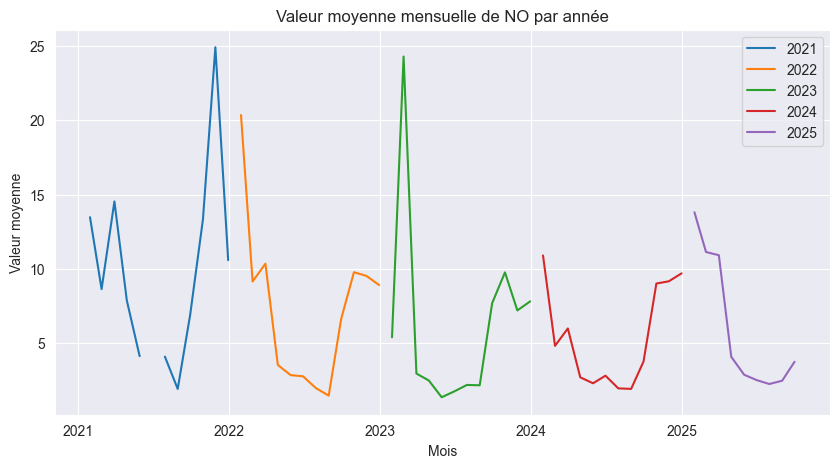

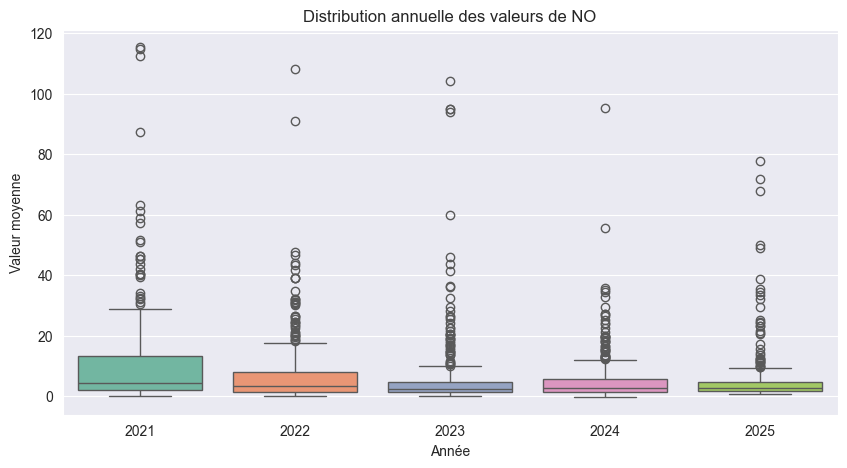

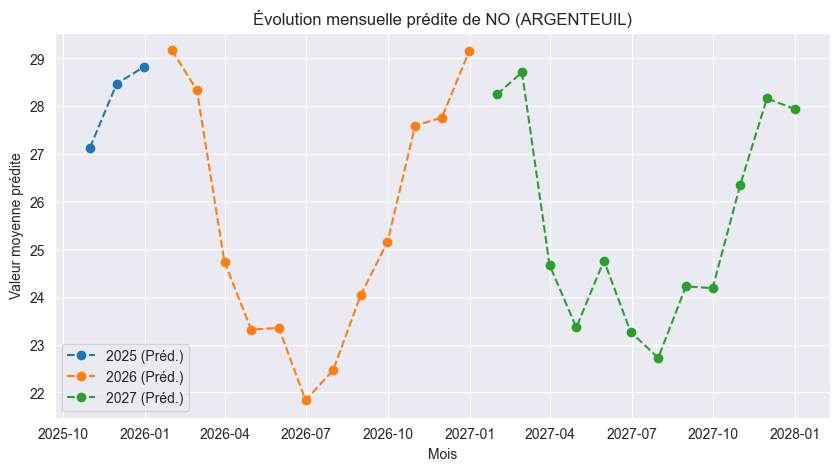

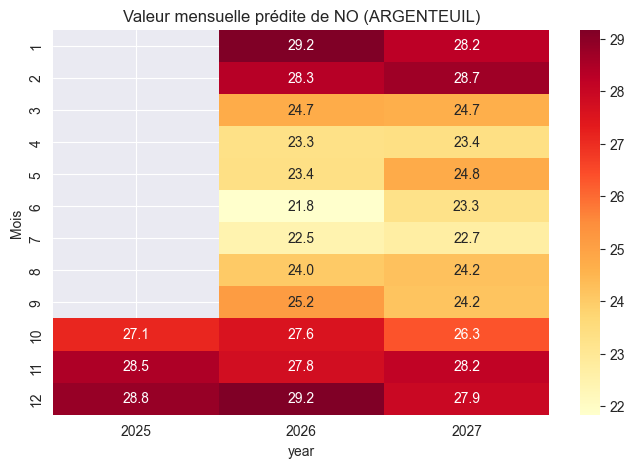

In [1]:
import streamlit as st
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

st.set_page_config(layout="wide")
st.title("Comparatif annuel et visualisations des polluants")

# ==========================
# SECTION 1 : DONNÉES HISTORIQUES
# ==========================

# --- Chargement des données historiques ---
df = pd.read_csv("data/all_years_grouped_data.csv", delimiter=';')
df['Jour'] = pd.to_datetime(df['Jour'])
colonnes_numeriques = ['valeur_minimale', 'valeur_maximale', 'valeur_moyenne']
for col in colonnes_numeriques:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Extraction des années disponibles
annees = sorted(df['Jour'].dt.year.unique())

# --- Filtres ---
st.sidebar.header("Filtres - Historique")
sites = df['nom site'].unique()
site_selection = st.sidebar.selectbox("Choisissez un site", sites)

polluants = df['Polluant'].unique()
polluant_selection = st.sidebar.selectbox("Choisissez un polluant", polluants)

annees_selection = st.sidebar.multiselect("Choisissez une ou plusieurs années", annees, default=annees)

influences = df['type d\'influence'].unique()
influence_selection = st.sidebar.multiselect("Type d'influence", influences, default=influences)

implantations = df['type d\'implantation'].unique()
implantation_selection = st.sidebar.multiselect("Type d'implantation", implantations, default=implantations)

# --- Filtrage ---
df_filtered = df[
    (df['nom site'] == site_selection) &
    (df['Polluant'] == polluant_selection) &
    (df['Jour'].dt.year.isin(annees_selection)) &
    (df['type d\'influence'].isin(influence_selection)) &
    (df['type d\'implantation'].isin(implantation_selection))
]

st.subheader(f"📊 Évolution annuelle des valeurs moyennes de {polluant_selection} au site {site_selection}")

# --- Graphique 1 : évolution mensuelle ---
fig1, ax1 = plt.subplots(figsize=(10, 5))
for annee in annees_selection:
    df_year = df_filtered[df_filtered['Jour'].dt.year == annee].copy()
    if df_year.empty:
        continue
    df_year = df_year.set_index('Jour')

    df_year_num = df_year.select_dtypes(include=['number'])
    df_year_resampled = df_year_num.resample('M').mean().reset_index()

    ax1.plot(df_year_resampled['Jour'], df_year_resampled['valeur_moyenne'], label=str(annee))

ax1.set_ylabel("Valeur moyenne")
ax1.set_xlabel("Mois")
ax1.set_title(f"Valeur moyenne mensuelle de {polluant_selection} par année")
ax1.legend()
st.pyplot(fig1)

# --- Graphique 2 : distribution annuelle (Boxplot) ---
st.subheader("📦 Distribution annuelle des valeurs")

fig2, ax2 = plt.subplots(figsize=(10,5))
sns.boxplot(
    x=df_filtered['Jour'].dt.year,
    y=df_filtered['valeur_moyenne'],
    palette="Set2",
    ax=ax2
)
ax2.set_xlabel("Année")
ax2.set_ylabel("Valeur moyenne")
ax2.set_title(f"Distribution annuelle des valeurs de {polluant_selection}")
st.pyplot(fig2)


# ==========================
# SECTION 2 : PRÉDICTIONS FUTURES
# ==========================

st.header("🔮 Visualisations des prédictions")

# --- Chargement des prédictions futures ---
df_future = pd.read_csv("data/predictions_valeur_moyenne_2027.csv")

# Normaliser les colonnes
df_future.columns = df_future.columns.str.strip().str.lower()
# Résultat attendu : ['year', 'month', 'polluant', 'nom site', 'valeur_moyenne_predite']

# Renommer pour cohérence
df_future = df_future.rename(columns={'valeur_moyenne_predite': 'valeur_moyenne'})

# Construire une vraie date (1er jour du mois)
df_future['jour'] = pd.to_datetime(
    dict(year=df_future['year'], month=df_future['month'], day=1),
    errors='coerce'
)

# --- Utilisation des mêmes filtres que l'historique ---
df_future_filtered = df_future[
    (df_future['nom site'] == site_selection) &
    (df_future['polluant'] == polluant_selection)
]

if df_future_filtered.empty:
    st.info("⚠️ Aucune donnée de prédiction pour ce site et polluant.")
else:
    # --- Graphique 1 : évolution mensuelle ---
    st.subheader(f"📈 Valeur moyenne prédite pour {polluant_selection} ({site_selection})")
    fig3, ax3 = plt.subplots(figsize=(10, 5))
    for annee in sorted(df_future_filtered['year'].unique()):
        df_year = df_future_filtered[df_future_filtered['year'] == annee].copy()
        df_year = df_year.set_index('jour')
        df_year_resampled = df_year[['valeur_moyenne']].resample('M').mean().reset_index()
        ax3.plot(df_year_resampled['jour'], df_year_resampled['valeur_moyenne'],
                 linestyle="--", marker="o", label=f"{annee} (Préd.)")

    ax3.set_ylabel("Valeur moyenne prédite")
    ax3.set_xlabel("Mois")
    ax3.set_title(f"Évolution mensuelle prédite de {polluant_selection} ({site_selection})")
    ax3.legend()
    st.pyplot(fig3)

    # --- Graphique 2 : heatmap mensuelle ---
    st.subheader("🌡️ Heatmap mensuelle des prédictions")
    df_future_filtered['mois'] = df_future_filtered['jour'].dt.month
    pivot = df_future_filtered.pivot_table(
        index='mois',
        columns='year',
        values='valeur_moyenne',
        aggfunc='mean'
    )

    fig5, ax5 = plt.subplots(figsize=(8,5))
    sns.heatmap(pivot, annot=True, fmt=".1f", cmap="YlOrRd", ax=ax5)
    ax5.set_title(f"Valeur mensuelle prédite de {polluant_selection} ({site_selection})")
    ax5.set_ylabel("Mois")
    st.pyplot(fig5)
